In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/Users/mbedell/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return np.sqrt(frac)

In [3]:
MODEL_T_COLOR = 'b'
MODEL_STAR_COLOR = 'r'
DATA_COLOR = 'k'

## 51 Peg:

In [4]:
results = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt0.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt0.hdf5


### FIGURE: data and models for random epoch

In [30]:
r = 56 # order
n = 50 # epoch

In [31]:
data = wobble.Data(results.origin_file, filepath='/Users/mbedell/python/wobble/', 
                   orders=[r], epochs=[n])

In [32]:
xs = np.exp(data.xs[0][0])
ys = np.exp(data.ys[0][0])
mask = data.ivars[0][0] <= 1.e-8
resids = ys - np.exp(results.star_ys_predicted[r][n] 
                            + results.tellurics_ys_predicted[r][n])

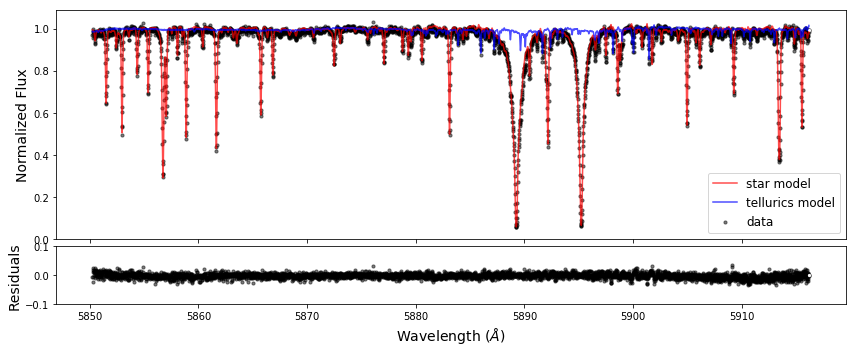

In [33]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5))
ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
ax.plot(xs, np.exp(results.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.7)
ax.plot(xs, np.exp(results.tellurics_ys_predicted[r][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.5, alpha=0.7)
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)

ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('51peg_fit.png')

### FIGURE: orbit fit

In [17]:
from numpy import log, exp, pi, sqrt, sin, cos, tan, arctan

def calc_ma(T0, t, period):
    # calculate mean anomaly
    days = t - T0
    phase = days/period % 1.0
    ma = phase * 2.0 * pi
    return ma
    
def calc_ea(ma, ecc):
    # calculate eccentric anomaly from mean anomaly, eccentricity
    tolerance = 1e-3
    ea = np.copy(ma)
    while True:
        diff = ea - ecc * sin(ea) - ma
        ea -= diff / (1. - ecc * cos(ea))
        if abs(diff).all() <= tolerance:
            break
    return ea
 
    
def calc_rvs(t,par):
    '''
    Calculate RV(t) given par
    par: [period, K, ecc, omega, M0, offset]
    where omega is the argument of periastron
    and Tp is time at periastron
    '''
    P,K,ecc,omega,tp,offset = par
    
    # enforce boundaries on parameters:
    #if (P < 0.0 or K < 0.0 or ecc < 0.0 or ecc > 0.999 or omega < 0. or omega > 2.*pi or M0 < 0. or M0 > 2.*pi):
    #    return np.zeros_like(t)
    #P = max([0.0, P])
    #K = max([0.0, K])
    #ecc = min([max([0.0, ecc]), 0.99])
    #omega = min([max([-pi, omega]), pi])
    #M0 = min([max([-pi, M0]), pi])
    
    ma = 2. * pi / P * (t - tp)  # mean anomaly
    ea = calc_ea(ma, ecc)  # eccentric anomaly

    f = 2.0 * np.arctan2(sqrt(1+ecc)*sin(ea/2.0), sqrt(1-ecc)*cos(ea/2.0)) # true anomaly
    rvs = - K * (cos(omega + f) + ecc*cos(omega))
    return rvs + offset

def calc_msini(P, K, ecc, Mstar=1.0):
    '''
    works in the limit that msini << Mstar
    takes:
    K - RV semi-amplitude in m/s
    P - period in days
    ecc - eccentricity (dimensionless)
    Mstar - host star mass in solar masses (default 1)
    returns:
    msini - minimum mass in Jupiters
    '''
    scaled_k = np.abs(K) / 28.4329 * np.sqrt(1. - ecc**2)
    msini = scaled_k * (P / 365.)**(1./3.) * Mstar**(2./3.)
    return msini

    
def keplerian(par,x):
    return calc_rvs(x, par)

def resid(par,fn,x,y,yerr):
    model = fn(par,x)
    return (y - model)/yerr 

In [25]:
rvs = results.star_time_rvs + results.bervs
sigs = np.ones_like(rvs) # HACK!!!!
dates = results.dates - 2450000

In [26]:
from scipy.optimize import leastsq
par0 = np.asarray([4.2308, 55.65, 0.001, 90 * np.pi/180., 0., 0.])  # [period, K, ecc, omega, tp, offset]
soln = leastsq(resid, par0, args=(keplerian, dates, rvs, sigs))

chisq = 73.60
resids RMS = 0.90 m/s
planet period = 4.2307 days
planet msini = 0.45 MJup


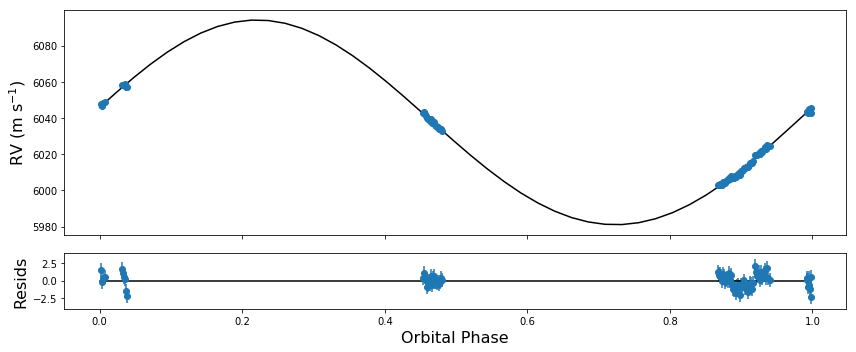

In [29]:
par = soln[0]
period = par[0]
date_fold = dates % period
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5))

ax1.errorbar(date_fold/period, rvs, sigs, fmt='o')
xs = np.arange(0.,period,0.1)
ax1.plot(xs/period, calc_rvs(xs, par), color='k')
#ax1.set_ylim([-80, 80])
ax1.set_xticklabels('',visible=False)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)

ax2.set_ylim([-4, 4])


resids = resid(par,keplerian,dates,rvs,sigs)
ax2.errorbar(date_fold/period, resids, sigs, fmt='o')
ax2.plot(xs/period, np.zeros_like(xs), color='k')
print('chisq = {0:.2f}'.format(np.sum(resids**2/sigs**2)))
print('resids RMS = {0:.2f} m/s'.format(np.std(resids)))
print('planet period = {0:.4f} days'.format(period))
print('planet msini = {0:.2f} MJup'.format(calc_msini(*par[:3])))
fig.subplots_adjust(hspace=.05)
ax2.set_ylabel('Resids', fontsize=16)
ax2.set_xlabel('Orbital Phase', fontsize=16)
fig.tight_layout()

## tellurics model 
#### (still using 51 Peg data)

### FIGURE: tellurics compared to standard star

In [34]:
from harps_hacks import read_harps
from wobble.utils import fit_continuum
f = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23:40:43.280_e2ds_A.fits'
wave,flux = read_harps.read_spec_2d(f)
snrs = read_harps.read_snr(f)
print(snrs[57])

ModuleNotFoundError: No module named 'harps_hacks'

In [47]:
o = 57
wave2,flux2 = np.exp(data.wobble_obj.model_xs_t[o]), np.exp(data.wobble_obj.model_ys_t[o])
wave1,flux1 = wave[o], flux[o]
ivars1 = np.zeros_like(flux1) + snrs[o]**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

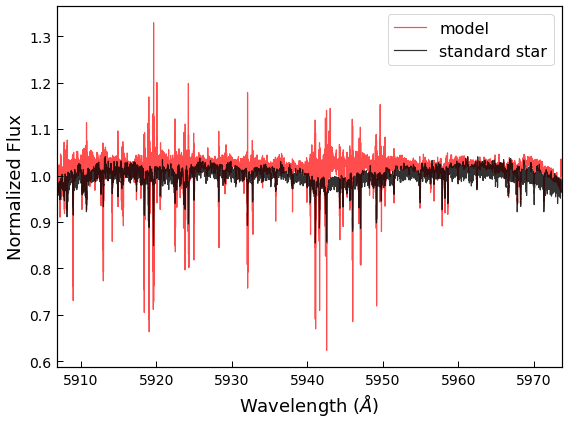

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wave2,flux2,color=MODEL_T_COLOR,alpha=0.7,label='model')
ax.plot(wave1,flux1,color=DATA_COLOR,alpha=0.8,label='standard star')
ax.set_xlim([min(wave2),max(wave2)])
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=18)
ax.set_ylabel('Normalized Flux', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
fig.tight_layout()
fig.savefig('telluric_standard.pdf')

### FIGURE: telluric components and variability

## quiet M star:

### FIGURE: data and models for random epoch

### FIGURE: time series